# Segmentation with Hough transform

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [110]:
def showImage(image, title): 
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])

def showImageBGR(image, title):
    showImage(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), title)

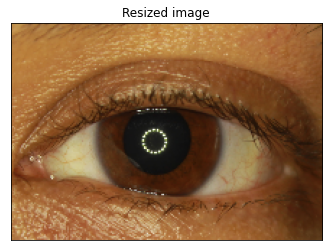

In [195]:
image = cv2.imread('L1.JPG')
M, N, C = image.shape
im_rgb_res = cv2.resize(image, (int(N/8),int(M/8)))
M2, N2, C2 = im_rgb_res.shape
im_rgb_foc = im_rgb_res[int(0.3*M2):int(0.65*M2), int(0.5*M2):int(M2)] 

showImageBGR(im_rgb_foc, "Resized image")

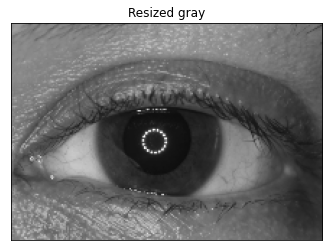

In [196]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
im_gray_res = cv2.resize(gray, (int(N/8),int(M/8)))
M2, N2 = im_gray_res.shape
im_gray_foc = im_gray_res[int(0.3*M2):int(0.65*M2), int(0.5*M2):int(M2)]

showImageBGR(im_gray_foc,"Resized gray")

## Removing Glare in the pupil

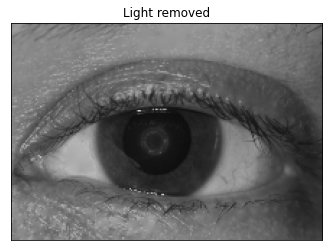

In [197]:
rgb = cv2.cvtColor(im_rgb_foc, cv2.COLOR_BGR2RGB)
h, s, v = cv2.split(cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV))
nonSat = s < 180 # Find all pixels that are not very saturated

# Slightly decrease the area of the non-satuared pixels by a erosion operation.
disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
nonSat = cv2.erode(nonSat.astype(np.uint8), disk)

# Set all brightness values, where the pixels are still saturated to 0.
v2 = v.copy()
v2[nonSat == 0] = 0;

glare = v2 > 200;    # filter out very bright pixels.
# Slightly increase the area for each pixel
glare = cv2.dilate(glare.astype(np.uint8), disk)
corrected = cv2.inpaint(im_gray_foc, glare, 20, cv2.INPAINT_NS)

showImageBGR(corrected,'Light removed')

## Contrast Enhancement

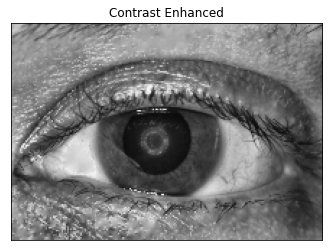

In [198]:
## CLAHE Equalization
cl1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe = cl1.apply(corrected)

showImageBGR(clahe,'Contrast Enhanced')

## Applying Hough circle transform

The same function was used for iris and pupil, but the values of (minRadius) and (maxRadius) were changed.


Note: This function succeeded in correct segmentation of 4 images out of 5

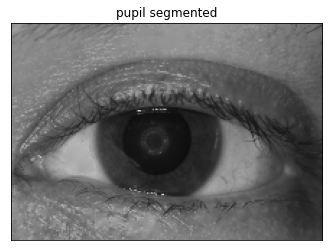

In [199]:
blur = cv2.medianBlur(clahe, 7)
## Detect Circles pupil                                                           
circles_pupil = cv2.HoughCircles(blur ,cv2.HOUGH_GRADIENT,1,20,                
                            param1=50,param2=30,minRadius=10,maxRadius=30)   ## 30,50 first image

x_pupil = 0
y_pupil = 0
r_pupil = 0
copy = corrected.copy()
if circles_pupil is not None:
    for circle in circles_pupil[0,:]:
        # draw the outer circle
        #cv2.circle(copy,(circle[0],circle[1]),circle[2],(0,255,0),1)
        x_pupil = circle[0]
        y_pupil = circle[1]
        r_pupil = circle[2]
showImageBGR(copy,'pupil segmented')


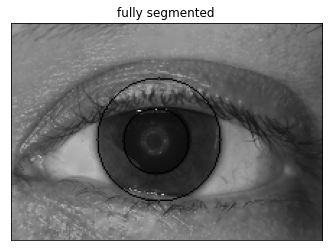

In [200]:
### Iris Segmentation                                                           
circles_iris = cv2.HoughCircles(blur ,cv2.HOUGH_GRADIENT,1,20,                
                            param1=50,param2=30,minRadius=30,maxRadius=50)   ## 30,50 first image

x_iris = 0
y_iris = 0
r_iris = 0
copy = corrected.copy()
if circles_iris is not None:
    for Circle in circles_iris[0,:]:
        # draw the outer circle
        #cv2.circle(copy,(circle[0],circle[1]),circle[2],(0,255,0),1)
        x_iris = Circle[0]
        y_iris = Circle[1]
        r_iris = Circle[2]
pupil_segmented = cv2.circle(copy,(x_pupil,y_pupil),r_pupil,(0,255,0),1) 
iris_segmented = cv2.circle(pupil_segmented,(x_iris,y_iris),r_iris,(0,255,0),1)
showImageBGR(iris_segmented,'fully segmented')